# Aleket Faster R-CNN training notebook

In [1]:
# IMPORTS

# Standard Library
import random
import os

# Third-Party Libraries
import numpy as np
from matplotlib import pyplot as plt

# Torch
import torch

# Utils
from aleket_dataset import AleketDataset, download_dataset
from utils import split_dataset, get_model
from training_and_evaluation import train
from dataset_statisics import visualize_samples, count_analyze
from run_params import RunParams, parse_params

In [2]:
# Helper functions
def augment_example(ds):
    examples = visualize_samples(ds, image_ids_to_visualize=range(4))
    fig=plt.figure(figsize=(40, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(examples[i-1])
    plt.show()

In [ ]:
# Device Selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Random Seed for Reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
np_generator = np.random.default_rng(SEED)

# Dataset split
DATASET_FRACTION = 1
VALIDATION_FRACTION = 0.2
dataset = AleketDataset(download_dataset("dataset_patched", ""))
train_set, val_set = split_dataset(dataset, DATASET_FRACTION, VALIDATION_FRACTION, np_generator)

# Model
model = get_model(device)

print(f"Using model: {model._get_name()}")

Using device: cuda
Dataset loaded from dataset_patched
Using model: FasterRCNN


In [4]:
RUN_NAME = "run_local"

params = RunParams(
    run_name=RUN_NAME,
    batch_size=16,
    dataloader_workers=16, 
    total_epochs=1000,
    augmentation={
        "horizontal_flip": {
            "p": 0.5
        },
        "vertical_flip": {
            "p": 0.5
        },
        "perspective": {
            "distortion_scale": 0.2,
            "p": 0.5
        },
        "rotation": {
            "degrees": 15,
            "expand": True
        },
        "color_jitter": {
            "brightness": 0.2,
            "contrast": 0.1,
            "saturation": 0.05
        }
    },
    optimizer={
        "lr": 0.001,
        "momentum": 0.9,
        "weight_decay": 0.0001
    },
    lr_scheduler={
        "factor": 0.5,
        "patience": 10,
        "min_lr": 0.0001
    },
    validation_set=val_set,
    train_set=train_set
    )


print(f"Train parameters for '{RUN_NAME}'")

Train parameters for 'run_local'


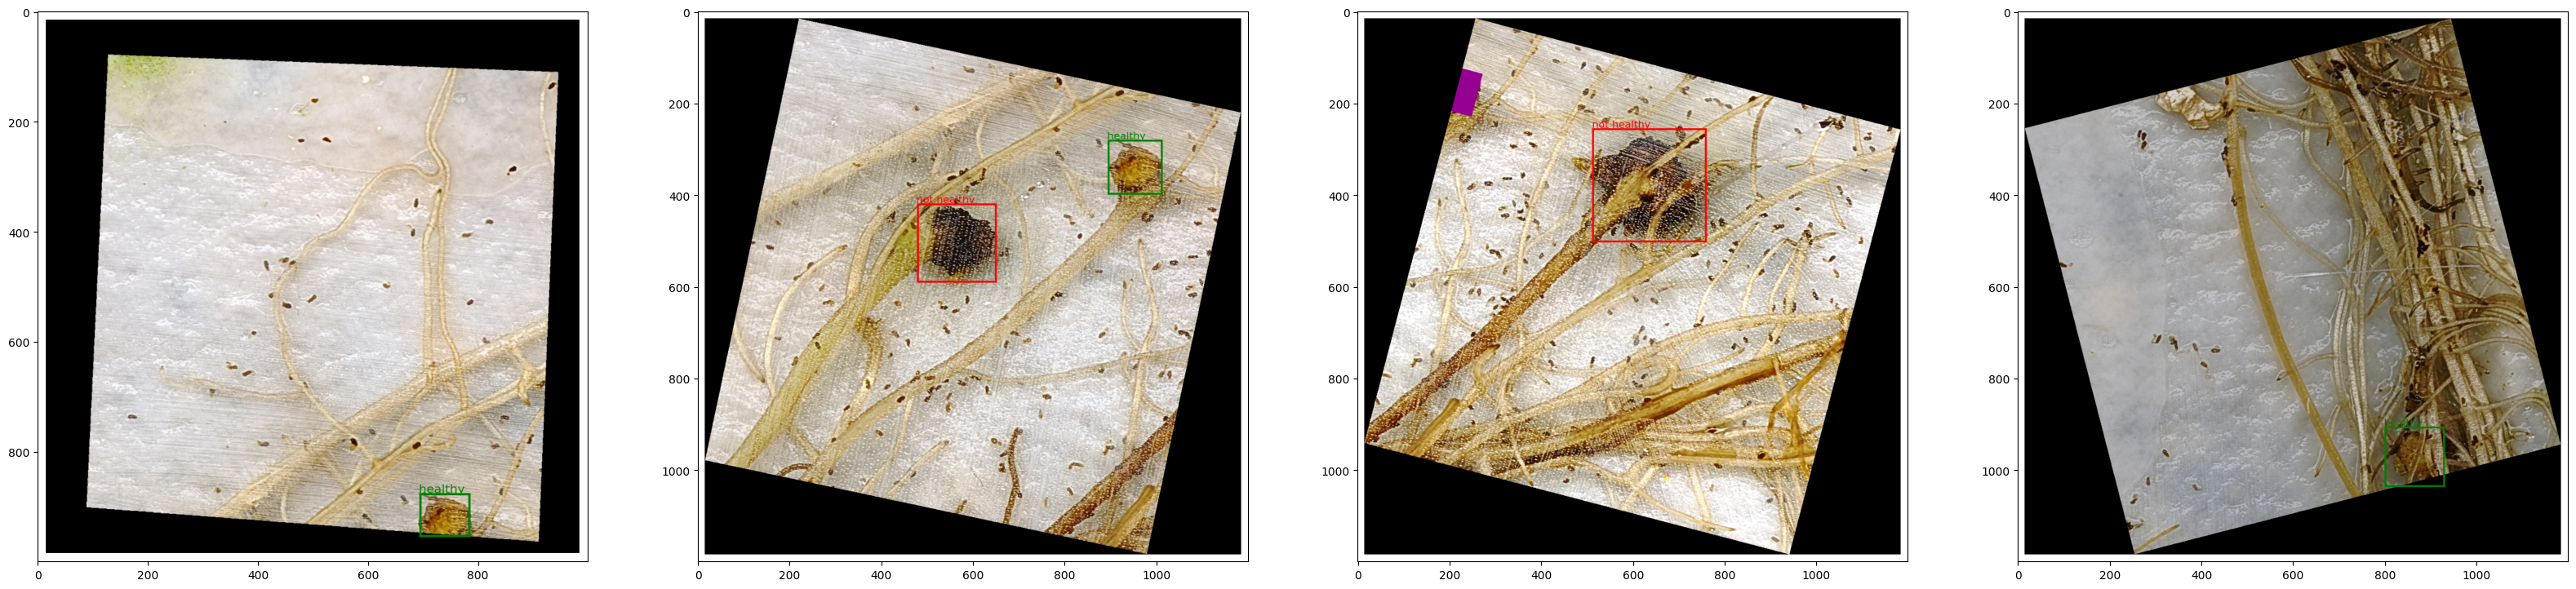

In [5]:
parsed_params = parse_params(params, model, dataset)
train_dataloader = parsed_params["train_loader"]
val_dataloader = parsed_params["val_loader"]
augmentation = parsed_params["augmentation"]

count_analyze(dataset, save_folder="patched_dataset_statistics")
count_analyze(dataset, indices=train_dataloader.dataset.indices, save_folder="patched_train_dataset_statistics")
count_analyze(dataset, indices=val_dataloader.dataset.indices, save_folder="patched_val_dataset_statistics")

dataset.augmentation = augmentation
augment_example(train_dataloader.dataset)

In [ ]:
train(model, dataset, params, device, checkpoints=True)

In [ ]:
params.load(os.path.join()) # override parameters
train(model, dataset, params, device, checkpoints=True, resume=True)